In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [17]:
df = pd.read_csv(
    "https://github.com/monatagelsir7/sephora_products_analysis/raw/refs/heads/main/data/sephora_website_dataset.csv"
)

## Brand Positionning

In [18]:
df2 = df.copy()
df2.columns

Index(['id', 'brand', 'category', 'name', 'size', 'rating',
       'number_of_reviews', 'love', 'price', 'value_price', 'URL',
       'MarketingFlags', 'MarketingFlags_content', 'options', 'details',
       'how_to_use', 'ingredients', 'online_only', 'exclusive',
       'limited_edition', 'limited_time_offer'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Filter data where rating > 0
filtered = df2[df2["rating"] > 0]

# Step 2: Group by brand and aggregate
brand_perf = (
    filtered
    .groupby("brand")
    .agg({
        "rating": "mean",
        "number_of_reviews": "sum",
        "id": "count",  # number of products
        "price": "mean"
    })
    .rename(columns={
        "id": "product_count",
        "price": "avg_price"
    })
)

# Step 3: Keep only meaningful brands (20+ products, 100+ reviews)
brand_perf = brand_perf.query("product_count >= 20 and number_of_reviews >= 100")

# Step 4: Normalize rating and number_of_reviews
scaler = MinMaxScaler()
brand_perf["reviews_norm"] = scaler.fit_transform(brand_perf[["number_of_reviews"]])
brand_perf["rating_norm"] = scaler.fit_transform(brand_perf[["rating"]])

# Step 5: Compute composite score (60% reviews, 40% rating)
brand_perf["composite_score"] = (
    0.5 * brand_perf["reviews_norm"] +
    0.5 * brand_perf["rating_norm"]
)

# Step 6: Get top 7 brands
top_brands = brand_perf.nlargest(7, "composite_score")
top_brands



,rating,number_of_reviews,product_count,avg_price,reviews_norm,rating_norm,composite_score
brand,,,,,,,
SEPHORA COLLECTION,4.108602,121095,465,18.206344,1.000000,0.523904,0.761952
Anastasia Beverly Hills,4.316176,76924,68,26.139706,0.634793,0.722133,0.678463
CLINIQUE,4.196347,85435,219,30.045662,0.705163,0.607698,0.656430
Urban Decay,4.155405,87273,74,27.567568,0.720359,0.568600,0.644480
KVD Vegan Beauty,4.142857,86103,70,27.814286,0.710686,0.556617,0.633651
Benefit Cosmetics,4.094444,87237,90,24.622222,0.720062,0.510384,0.615223
Too Faced,4.076923,88405,78,30.705128,0.729719,0.493651,0.611685


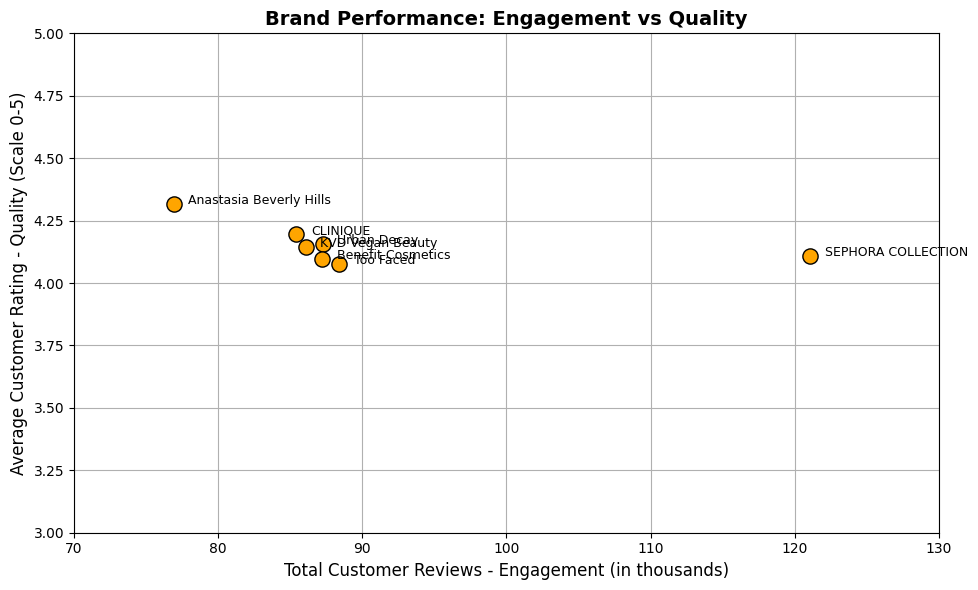

In [20]:
plot_data = top_brands.copy()

plt.figure(figsize=(10, 6))
plt.scatter(
    plot_data["number_of_reviews"],
    plot_data["rating"],
    color="orange",
    edgecolor="black",
    s=120  # bubble size
)

# # Add labels
for brand, row in plot_data.iterrows():
    plt.text(
        row["number_of_reviews"] + 1000,
        row["rating"],
        brand,
        fontsize=9
    )

# Titles and labels
plt.title("Brand Performance: Engagement vs Quality", fontsize=14, fontweight='bold')
plt.xlabel("Total Customer Reviews - Engagement (in thousands)", fontsize=12)
plt.ylabel("Average Customer Rating - Quality (Scale 0-5)", fontsize=12)

# Better axis ranges
plt.xlim(70000, 130000)
plt.ylim(3, 5.0)


plt.xticks(
    ticks=range(70000, 130001, 10000),
    labels=[str(x // 1000) for x in range(70000, 130001, 10000)]
)

plt.grid(True)
plt.savefig("bubblet.svg")
plt.tight_layout()
plt.show()

## How Sephora scores based on number of products compared to other brands

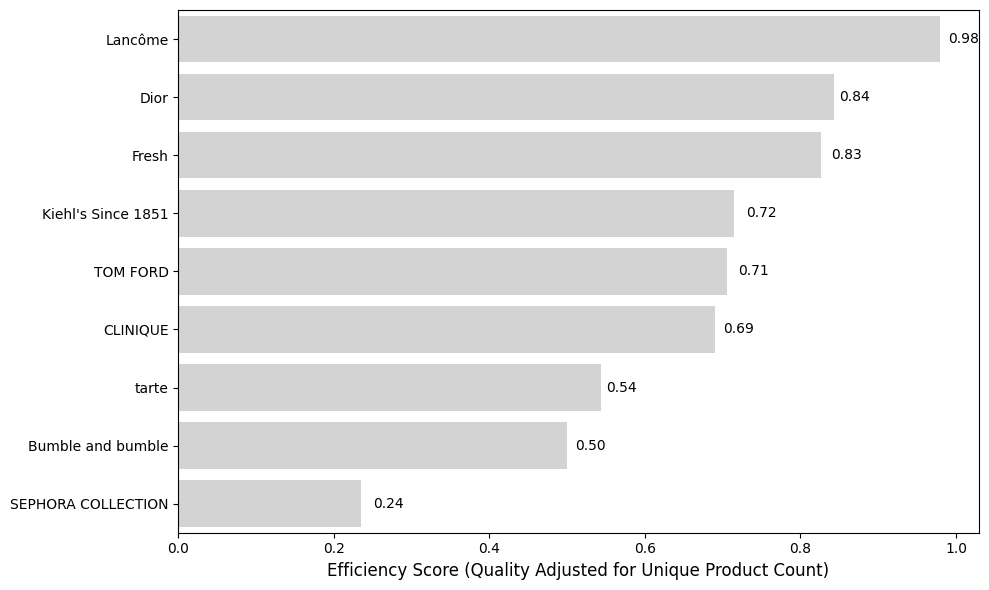

In [21]:

from sklearn.preprocessing import MinMaxScaler


# Step 1: Drop duplicate product names to count only unique products (not SKUs)
unique_df = df2[df2["rating"] > 0].drop_duplicates(subset="name")

# Step 2: Group by brand and summarize
brand_perf = (
    unique_df
    .groupby("brand")
    .agg({
        "rating": "mean",               # average quality
        "number_of_reviews": "sum",     # total reviews (engagement)
        "name": "count"                 # number of unique products (by name)
    })
    .rename(columns={"name": "product_count"})  # rename for clarity
    .query("product_count >= 100 and number_of_reviews >= 200")  # filter big brands
)

# Step 3: Normalize rating and product count
scaler = MinMaxScaler()
brand_perf["rating_norm"] = scaler.fit_transform(brand_perf[["rating"]])
brand_perf["size_norm"] = scaler.fit_transform(brand_perf[["product_count"]])

# Step 4: Invert size — smaller catalog is better
brand_perf["inverse_size_norm"] = 1 - brand_perf["size_norm"]

# Step 5: Compute efficiency score (balance quality & catalog size)
brand_perf["efficiency_score"] = (
    0.5 * brand_perf["rating_norm"] +
    0.5 * brand_perf["inverse_size_norm"]
)

# Step 6: Select top efficient brands (optional — remove `.head(10)` for all)
top_efficient = brand_perf.sort_values("efficiency_score", ascending=False)

# Step 7: Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_efficient,
    x="efficiency_score",
    y=top_efficient.index,
    color="lightgray"  
)

# Add score labels
for i, score in enumerate(top_efficient["efficiency_score"].round(2)):
    plt.text(score + 0.01, i, f"{score:.2f}", va="center")

# Final touches
plt.xlabel("Efficiency Score (Quality Adjusted for Unique Product Count)", fontsize=12)
plt.ylabel(None)
plt.title(None)
plt.tight_layout()
plt.savefig("comparison.svg", bbox_inches='tight')

plt.show()


STARTING BRAND PERFORMANCE ANALYSIS
Total brands in dataset: 324
Brands with 20+ products & 100+ reviews: 147
Selected Top 7 Brands for Analysis:
                         rating  number_of_reviews  product_count
brand                                                            
SEPHORA COLLECTION        4.109             121095            465
Anastasia Beverly Hills   4.316              76924             68
CLINIQUE                  4.196              85435            219
Urban Decay               4.155              87273             74
KVD Vegan Beauty          4.143              86103             70
Benefit Cosmetics         4.094              87237             90
Too Faced                 4.077              88405             78

VISUALIZATION 1: Core Relationship - Quality vs Engagement


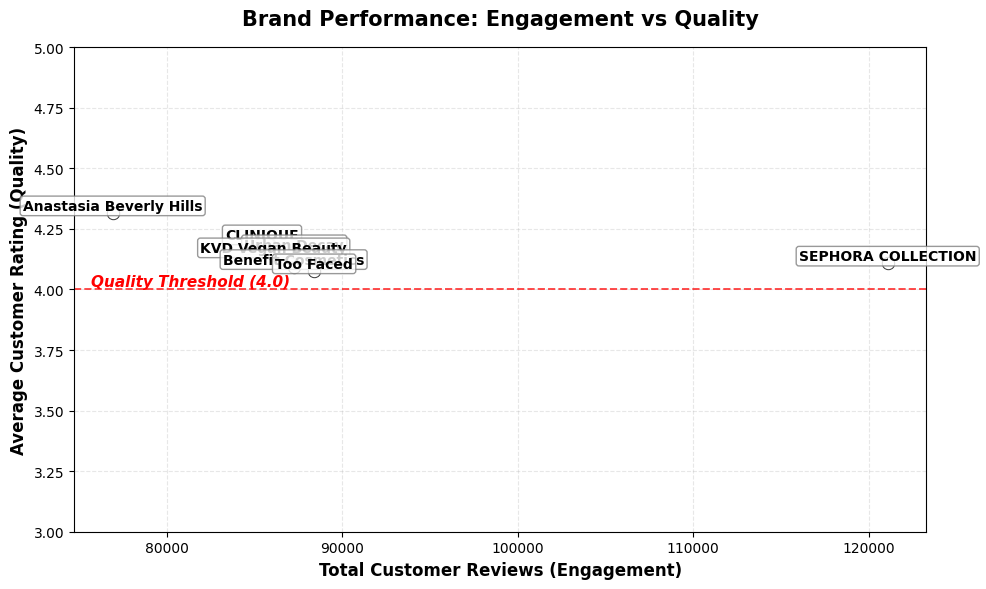


VISUALIZATION 2: Catalog Size Analysis


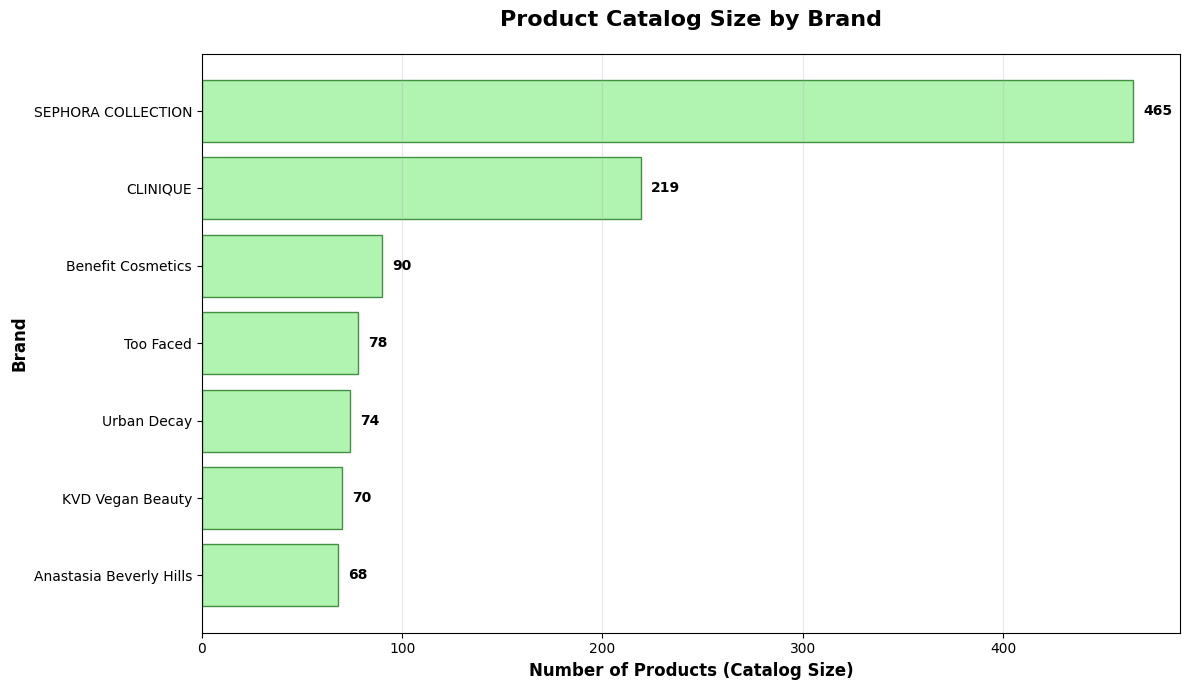


VISUALIZATION 3: Category Performance
Note: 'Category3' column not found. Using brand-level data only.
No category data available. Showing brand comparison instead.


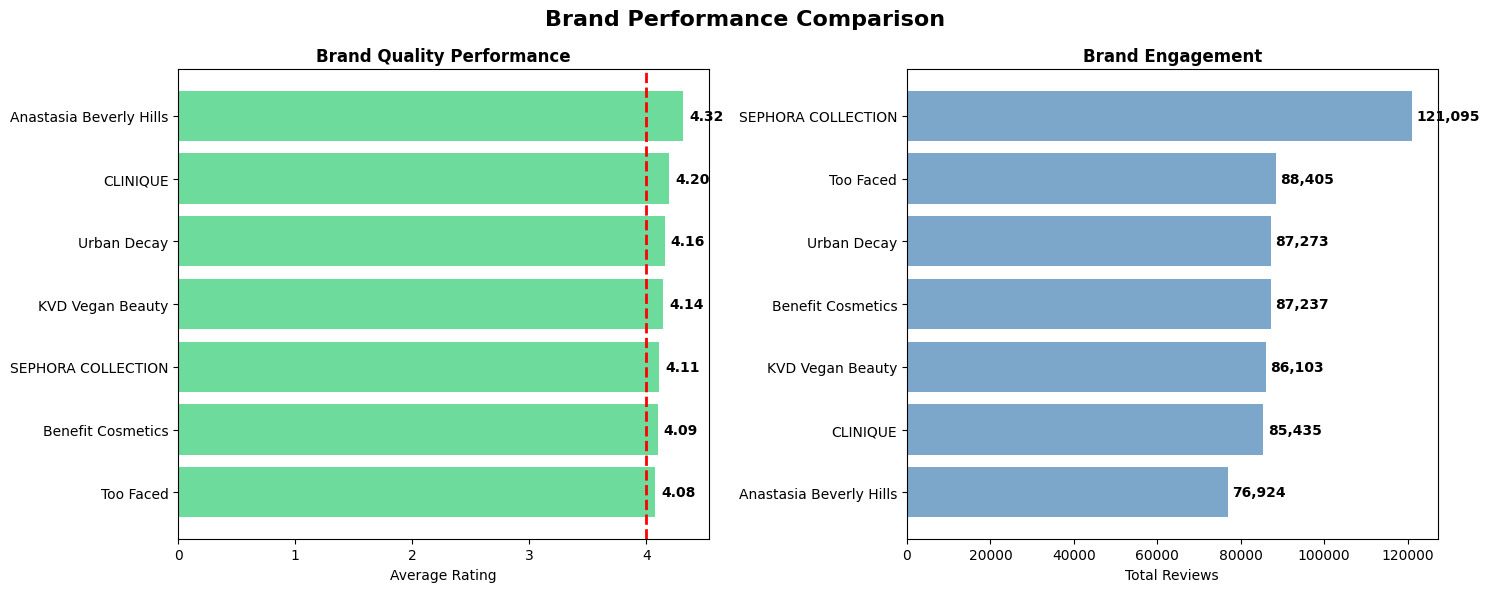

KEY INSIGHTS SUMMARY

1. QUALITY PERFORMANCE (Threshold: 4.0):
   • Brands meeting quality standard: 7
   • Brands below quality standard: 0
   • Highest quality: Anastasia Beverly Hills (4.32 rating)

2. ENGAGEMENT LEADERS:
   • Highest engagement: SEPHORA COLLECTION (121,095 reviews)

3. CATALOG SIZE:
   • Largest catalog: SEPHORA COLLECTION (465 products)


In [22]:

# Set consistent style
plt.style.use("default")
sns.set_palette("husl")

# Define consistent quality threshold
QUALITY_THRESHOLD = 4.0
data = pd.read_csv(
    "https://github.com/monatagelsir7/sephora_products_analysis/raw/refs/heads/main/data/sephora_website_dataset.csv"
)


def prepare_brand_data(data):
    """Prepare brand performance data with consistent filtering"""

    brand_perf = (
        data[data["rating"] > 0]
        .groupby("brand")
        .agg(
            {
                "rating": "mean",
                "number_of_reviews": "sum",
                "id": "count",  # number of products
                "price": "mean",
            }
        )
        .rename(columns={"id": "product_count", "price": "avg_price"})
        .query("product_count >= 20 & number_of_reviews >= 100")
        .sort_values("number_of_reviews", ascending=False)
    )

    # Select top brands using composite score
    scaler = MinMaxScaler()
    brand_perf["reviews_norm"] = scaler.fit_transform(brand_perf[["number_of_reviews"]])
    brand_perf["rating_norm"] = scaler.fit_transform(brand_perf[["rating"]])
    brand_perf["composite_score"] = (0.6 * brand_perf["reviews_norm"]) + (
        0.4 * brand_perf["rating_norm"]
    )

    top_brands = brand_perf.nlargest(7, "composite_score").index.tolist()

    print(f"Total brands in dataset: {data['brand'].nunique()}")
    print(f"Brands with 20+ products & 100+ reviews: {len(brand_perf)}")
    print(f"Selected Top 7 Brands for Analysis:")
    print(
        brand_perf.loc[top_brands][
            ["rating", "number_of_reviews", "product_count"]
        ].round(3)
    )

    return brand_perf, top_brands


# VISUALIZATION 1: CORE RELATIONSHIP - Rating vs Engagement
def plot_rating_vs_engagement(plot_data, QUALITY_THRESHOLD=4.0, label_top_n=8):
    """
    Scatter plot of Engagement (reviews) vs Quality (rating).
    - Automatically adjusts brand labels to prevent overlap.
    - Removes explanatory legend box for a cleaner executive version.
    """

    import numpy as np
    import matplotlib.pyplot as plt
    # from adjustText import adjust_text

    # --- Pick top brands to label ---
    score = (plot_data["rating"] - QUALITY_THRESHOLD).clip(lower=0) + (
        plot_data["number_of_reviews"] / plot_data["number_of_reviews"].max()
    )
    top_labels = set(plot_data.assign(score=score).nlargest(label_top_n, "score").index)

    fig, ax = plt.subplots(figsize=(10, 6))

    # --- Scatter points ---
    ax.scatter(
        plot_data["number_of_reviews"],
        plot_data["rating"],
        s=80,
        facecolors="white",
        edgecolors="black",
        linewidth=0.7,
        alpha=0.8,
    )

    # --- Annotate top brands ---
    texts = []
    for brand, x, y in zip(
        plot_data.index, plot_data["number_of_reviews"], plot_data["rating"]
    ):
        if brand in top_labels:
            texts.append(
                ax.text(
                    x,
                    y,
                    brand,
                    fontsize=10,
                    fontweight="bold",
                    color="black",
                    ha="center",
                    va="bottom",
                    bbox=dict(
                        facecolor="white",
                        edgecolor="gray",
                        alpha=0.8,
                        boxstyle="round,pad=0.2",
                    ),
                )
            )

    # # Automatically adjust overlapping labels
    # adjust_text(
    #     texts,
    #     only_move={"points": "y", "texts": "xy"},
    #     arrowprops=dict(arrowstyle="-", color="gray", lw=0.7, alpha=0.7),
    #     expand_text=(1.2, 1.4),
    #     expand_points=(1.4, 1.2),
    #     force_text=(0.8, 0.9),
    #     force_points=(0.8, 0.9),
    #     ax=ax,
    # )

    # Threshold line + label (consistent placement)
    ax.axhline(
        y=QUALITY_THRESHOLD, color="red", linestyle="--", alpha=0.7, linewidth=1.4
    )
    ax.annotate(
        f"Quality Threshold ({QUALITY_THRESHOLD:.1f})",
        xy=(0.02, QUALITY_THRESHOLD),
        xycoords=("axes fraction", "data"),
        ha="left",
        va="bottom",
        fontsize=11,
        color="red",
        fontweight="bold",
        style="italic",
    )
    ax.set_xlabel("Total Customer Reviews (Engagement)", fontweight="bold", fontsize=12)
    ax.set_ylabel("Average Customer Rating (Quality)", fontweight="bold", fontsize=12)
    ax.set_title(
        "Brand Performance: Engagement vs Quality",
        fontsize=15,
        fontweight="bold",
        pad=16,
    )
    ax.grid(alpha=0.3, linestyle="--")
    xmin, xmax = (
        plot_data["number_of_reviews"].min(),
        plot_data["number_of_reviews"].max(),
    )
    xr = xmax - xmin
    ax.set_xlim(xmin - 0.05 * xr, xmax + 0.05 * xr)
    ax.set_ylim(3.0, 5.0)

    fig.tight_layout()
    plt.show()
    return fig


# VISUALIZATION 2: CATALOG SIZE
def plot_catalog_size(plot_data):
    """Separate plot for catalog size analysis"""

    fig, ax = plt.subplots(figsize=(12, 7))

    # Sort by catalog size for better visualization
    plot_data_sorted = plot_data.sort_values("product_count", ascending=True)

    # Show catalog size as horizontal bar plot
    bars = ax.barh(
        range(len(plot_data_sorted)),
        plot_data_sorted["product_count"],
        color="lightgreen",
        alpha=0.7,
        edgecolor="darkgreen",
    )

    ax.set_xlabel("Number of Products (Catalog Size)", fontweight="bold", fontsize=12)
    ax.set_ylabel("Brand", fontweight="bold", fontsize=12)
    ax.set_title(
        "Product Catalog Size by Brand", fontsize=16, fontweight="bold", pad=20
    )
    ax.set_yticks(range(len(plot_data_sorted)))
    ax.set_yticklabels(plot_data_sorted.index, fontsize=10)
    ax.grid(True, alpha=0.3, axis="x")

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(
            width + 5,
            bar.get_y() + bar.get_height() / 2,
            f"{int(width)}",
            ha="left",
            va="center",
            fontweight="bold",
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()

    return fig


# VISUALIZATION 3: FACETED CATEGORY PERFORMANCE
def prepare_category_data(data, top_brands):
    """Prepare category-level performance data"""

    # Check if Category3 column exists, if not use a default approach
    if "Category3" in data.columns:
        category_col = "Category3"
        categories = ["Skincare", "Makeup", "Hair Care"]
    else:
        # If no category column, create a simple version
        print("Note: 'Category3' column not found. Using brand-level data only.")
        return None

    category_brand_data = (
        data[data["brand"].isin(top_brands) & data[category_col].isin(categories)]
        .groupby(["brand", category_col])
        .agg({"rating": "mean", "number_of_reviews": "sum", "id": "count"})
        .rename(columns={"id": "products"})
        .reset_index()
    )

    return category_brand_data


def plot_faceted_category_performance(category_brand_data):
    """Faceted bar plot showing brand performance across categories"""

    if category_brand_data is None or category_brand_data.empty:
        print("No category data available. Skipping category visualization.")
        return None, None

    # Create faceted bar plot
    g = sns.FacetGrid(
        category_brand_data,
        col="Category3",
        col_wrap=3,
        height=5,
        aspect=1.2,
        sharey=False,
        sharex=True,
    )

    # Define colors based on threshold
    def get_color(rating):
        if rating >= QUALITY_THRESHOLD:
            return "#2ecc71"  # Green
        else:
            return "#e74c3c"  # Red

    # Plot each category
    for ax, category in zip(g.axes.flat, category_brand_data["Category3"].unique()):
        cat_data = category_brand_data[
            category_brand_data["Category3"] == category
        ].sort_values("rating")

        if not cat_data.empty:
            colors = [get_color(rating) for rating in cat_data["rating"]]
            bars = ax.barh(
                range(len(cat_data)),
                cat_data["rating"],
                color=colors,
                alpha=0.7,
                edgecolor="black",
                linewidth=0.5,
            )

            # Add threshold line
            ax.axvline(
                x=QUALITY_THRESHOLD, color="red", linestyle="--", alpha=0.7, linewidth=2
            )

            # Add value labels
            for i, (_, row) in enumerate(cat_data.iterrows()):
                ax.text(
                    row["rating"] + 0.05,
                    i,
                    f'{row["rating"]:.2f}',
                    va="center",
                    fontweight="bold",
                    fontsize=10,
                )

            # Add review count
            for i, (_, row) in enumerate(cat_data.iterrows()):
                ax.text(
                    3.6,
                    i,
                    f'({row["number_of_reviews"]:,} reviews)',
                    va="center",
                    fontsize=8,
                    style="italic",
                    color="gray",
                )

            ax.set_xlim(3.5, 5.0)
            ax.set_xlabel("Average Rating", fontweight="bold")
            ax.set_ylabel("")
            ax.set_title(f"{category}", fontweight="bold", pad=10, fontsize=12)
            ax.set_yticks(range(len(cat_data)))
            ax.set_yticklabels(cat_data["brand"], fontsize=10)
            ax.grid(True, alpha=0.3, axis="x")

    # Main title and labels
    plt.suptitle(
        f"Brand Performance by Category\n(Colors show performance relative to {QUALITY_THRESHOLD} threshold)",
        fontsize=16,
        fontweight="bold",
        y=1.02,
    )

    # Add legend
    g.fig.text(
        0.15,
        0.02,
        "■ Green: Meets quality standard  ■ Red: Below quality standard",
        fontsize=10,
        style="italic",
        color="#555555",
        fontweight="bold",
    )

    plt.tight_layout()
    plt.show()

    return g.fig, category_brand_data


# SIMPLE BRAND COMPARISON (if category data not available)


def plot_brand_comparison(plot_data):
    """Simple brand comparison when category data is not available"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Ratings comparison
    ratings_sorted = plot_data.sort_values("rating", ascending=True)
    colors = [
        "#e74c3c" if x < QUALITY_THRESHOLD else "#2ecc71"
        for x in ratings_sorted["rating"]
    ]
    bars1 = ax1.barh(
        range(len(ratings_sorted)), ratings_sorted["rating"], color=colors, alpha=0.7
    )
    ax1.axvline(QUALITY_THRESHOLD, color="red", linestyle="--", linewidth=2)
    ax1.set_yticks(range(len(ratings_sorted)))
    ax1.set_yticklabels(ratings_sorted.index)
    ax1.set_xlabel("Average Rating")
    ax1.set_title("Brand Quality Performance", fontweight="bold")

    # Add value labels
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(
            width + 0.05,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}",
            va="center",
            fontweight="bold",
        )

    # Plot 2: Engagement comparison
    reviews_sorted = plot_data.sort_values("number_of_reviews", ascending=True)
    bars2 = ax2.barh(
        range(len(reviews_sorted)),
        reviews_sorted["number_of_reviews"],
        color="steelblue",
        alpha=0.7,
    )
    ax2.set_yticks(range(len(reviews_sorted)))
    ax2.set_yticklabels(reviews_sorted.index)
    ax2.set_xlabel("Total Reviews")
    ax2.set_title("Brand Engagement", fontweight="bold")

    # Add value labels
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(
            width + 1000,
            bar.get_y() + bar.get_height() / 2,
            f"{width:,.0f}",
            va="center",
            fontweight="bold",
        )

    plt.suptitle("Brand Performance Comparison", fontsize=16, fontweight="bold", y=0.98)
    plt.tight_layout()
    plt.show()

    return fig


# INSIGHTS AND SUMMARY
def generate_insights(plot_data, category_brand_data=None):
    """Generate clear insights based on the visualizations"""

    print("=" * 60)
    print("KEY INSIGHTS SUMMARY")
    print("=" * 60)

    # Core performance insights
    above_threshold = plot_data[plot_data["rating"] >= QUALITY_THRESHOLD]
    below_threshold = plot_data[plot_data["rating"] < QUALITY_THRESHOLD]

    print(f"\n1. QUALITY PERFORMANCE (Threshold: {QUALITY_THRESHOLD}):")
    print(f"   • Brands meeting quality standard: {len(above_threshold)}")
    print(f"   • Brands below quality standard: {len(below_threshold)}")

    if not above_threshold.empty:
        best_quality = above_threshold.nlargest(1, "rating").index[0]
        best_rating = above_threshold.loc[best_quality, "rating"]
        print(f"   • Highest quality: {best_quality} ({best_rating:.2f} rating)")

    # Engagement insights
    top_engagement = plot_data.nlargest(1, "number_of_reviews").index[0]
    top_reviews = plot_data.loc[top_engagement, "number_of_reviews"]
    print(f"\n2. ENGAGEMENT LEADERS:")
    print(f"   • Highest engagement: {top_engagement} ({top_reviews:,} reviews)")

    # Catalog size insights
    largest_catalog = plot_data.nlargest(1, "product_count").index[0]
    catalog_size = plot_data.loc[largest_catalog, "product_count"]
    print(f"\n3. CATALOG SIZE:")
    print(f"   • Largest catalog: {largest_catalog} ({catalog_size} products)")

    # Category insights (if available)
    if category_brand_data is not None and not category_brand_data.empty:
        print(f"\n4. CATEGORY PERFORMANCE:")
        for category in category_brand_data["Category3"].unique():
            cat_data = category_brand_data[category_brand_data["Category3"] == category]
            if not cat_data.empty:
                best_in_cat = cat_data.nlargest(1, "rating")
                if not best_in_cat.empty:
                    brand = best_in_cat["brand"].iloc[0]
                    rating = best_in_cat["rating"].iloc[0]
                    status = (
                        "✓ Meets standard"
                        if rating >= QUALITY_THRESHOLD
                        else "✗ Below standard"
                    )
                    print(f"   • {category}: {brand} ({rating:.2f}) {status}")


def main(data):
    """Main execution function"""

    print("STARTING BRAND PERFORMANCE ANALYSIS")
    print("=" * 50)

    # Prepare data
    brand_perf, top_brands = prepare_brand_data(data)
    plot_data = brand_perf.loc[top_brands].copy()

    print("\n" + "=" * 50)
    print("VISUALIZATION 1: Core Relationship - Quality vs Engagement")
    print("=" * 50)
    plot_rating_vs_engagement(plot_data)

    print("\n" + "=" * 50)
    print("VISUALIZATION 2: Catalog Size Analysis")
    print("=" * 50)
    plot_catalog_size(plot_data)

    # Try to prepare category data
    print("\n" + "=" * 50)
    print("VISUALIZATION 3: Category Performance")
    print("=" * 50)

    category_brand_data = prepare_category_data(data, top_brands)

    if category_brand_data is not None and not category_brand_data.empty:
        category_plot, category_data = plot_faceted_category_performance(
            category_brand_data
        )
    else:
        print("No category data available. Showing brand comparison instead.")
        plot_brand_comparison(plot_data)
        category_data = None

    # Generate insights
    generate_insights(plot_data, category_data)


main(data)